In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
figsize = (30,5)

In [4]:
import librosa

In [5]:
wav_dict = {
    'starling': '/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav',
    'mouse': '/mnt/cube/Datasets/mouse_usv/VOC592/VOC592_VOC571_SONG_CMPA_9_20_2016_56_24.52.WAV',
    #'canary': '/mnt/cube/Datasets/canary/FromYarden2018/bird_3/bird3_0244_2004_03_14_14_15.wav',
    'canary': '/mnt/cube/Datasets/canary/FromYarden2018/bird_1/bird1_0001_2004_03_05_18_14.wav',
    'bengalese_finch': '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/bengalese_finch_sober/2019-09-02_17-08-52/WAV/or60yw70_300912_2036.4169.WAV'
}

In [6]:
wav_loc = wav_dict['starling']
#'/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav'

In [66]:
rate, data = load_wav(wav_loc)
#data = data[rate*20:rate*30]

In [67]:
data = butter_bandpass_filter(data, 500.0, rate/2-1, rate, order=2)

In [68]:
#data = data[rate*5:rate*10]

In [69]:
len(data)/rate

65.99

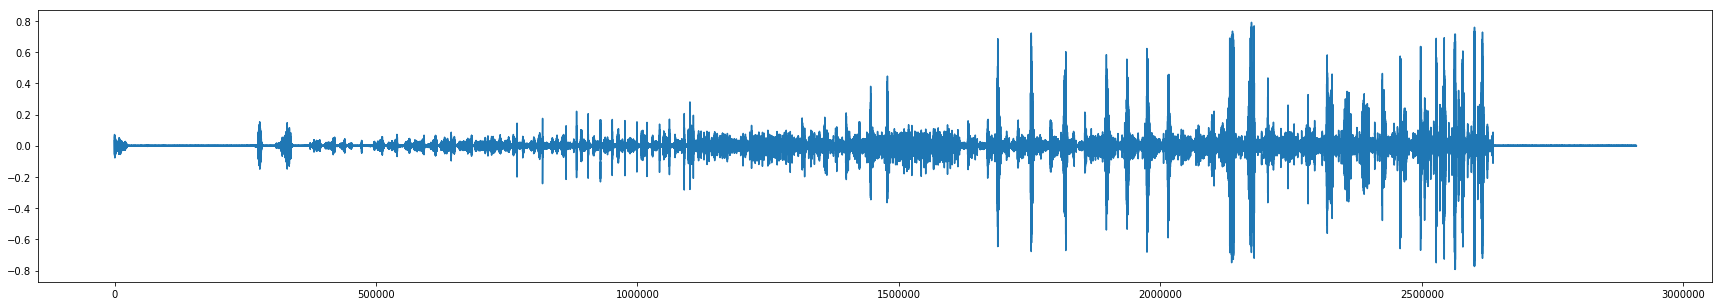

In [70]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data)

In [71]:

from avgn.visualization.spectrogram import plot_spec
import numpy as np
from tqdm.autonotebook import tqdm
from scipy import signal
import matplotlib
import librosa
import copy


def contiguous_regions(condition):
    """
    Compute contiguous region of binary value (e.g. silence in waveform) to ensure noise levels are sufficiently low
    """
    idx = []
    i = 0
    while i < len(condition):
        x1 = i + condition[i:].argmax()
        try:
            x2 = x1 + condition[x1:].argmin()
        except:
            x2 = x1 + 1
        if x1 == x2:
            if condition[x1] == True:
                x2 = len(condition)
            else:
                break
        idx.append([x1, x2])
        i = x2
    return idx

class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """

    def __init__(self, **kwargs):
        self.set_defaults()
        self.__dict__.update(kwargs)

    def set_defaults(self):
        self.win_length_ms = 5
        self.hop_length_ms = 1
        self.n_fft = 1024
        self.ref_level_db = 20
        self.min_level_db = -60
        self.preemphasis = 0.97

    def save(self):
        raise NotImplementedError

    def load(self):
        raise NotImplementedError

        
def _normalize(S, hparams):
    return np.clip((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)


def spectrogram(y, fs, hparams):
    return _normalize(spectrogram_nn(y, fs, hparams), hparams)


def spectrogram_nn(y, fs, hparams):
    D = _stft(preemphasis(y, hparams), fs, hparams)
    S = _amp_to_db(np.abs(D)) - hparams.ref_level_db
    return S

def preemphasis(x, hparams):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)


def _stft(y, fs, hparams):
    return librosa.stft(
        y=y,
        n_fft=hparams.n_fft,
        hop_length=int(hparams.hop_length_ms / 1000 * fs),
        win_length=int(hparams.win_length_ms / 1000 * fs),
    )

def zero_one_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def _amp_to_db(x):
    return 20 * np.log10(np.maximum(1e-5, x))


def dynamic_spectrogram(
    vocalization,
    rate,
    hparams,
    subtract_median = True,
    verbose=False,
):
    """computes a spectrogram from a waveform by iterating through thresholds to ensure a consistent noise level
        
        Arguments:
            vocalization {[type]} -- [description]
            rate {[type]} -- [description]
            hparams {[type]} -- [description]
             {[type]} -- [description]
        
        Keyword Arguments:
            _mel_basis {[type]} -- [description] (default: {None})
            subtract_median {bool} -- [description] (default: {True})
            mel_filter {bool} -- [description] (default: {False})
            verbose {bool} -- [description] (default: {False})
    """
    
    # does the envelope meet the standards necessary to consider this a bout
    envelope_is_good = False

    # make a copy of the hyperparameters
    hparams_current = copy.deepcopy(hparams)

    # make a copy of the original spectrogram
    spec_orig = spectrogram_nn(vocalization, rate, hparams)

    # loop through possible thresholding configurations starting at the highest
    for loopi, mldb in enumerate(
        tqdm(
            np.arange(
                hparams.min_level_db,
                hparams.min_level_db_floor,
                hparams.db_delta,
            ),
            leave=False,
            disable=(not verbose),
        )
    ):
        # set the minimum dB threshold
        hparams_current.min_level_db = mldb
        # normalize the spectrogram
        spec = zero_one_norm(_normalize(spec_orig, hparams_current))

        # subtract the median
        spec = spec - np.median(spec, axis=1).reshape((len(spec), 1))
        spec[spec < 0] = 0

        # get the vocal envelope
        vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))
        # normalize envelope
        vocal_envelope = vocal_envelope / np.max(vocal_envelope)

        # Look at how much silence exists in the signal
        cr_on = np.array(
            contiguous_regions(vocal_envelope <= hparams.silence_threshold)
        )
        cr_off = np.array(
            contiguous_regions(vocal_envelope > hparams.silence_threshold)  # / 10)
        )

        # if there is a silence of at least min_silence_for_spec length,
        #  and a vocalization of no greater than max_vocal_for_spec length, the env is good
        if len(cr_on) > 0:
            # frames per second of spectrogram
            fft_rate = 1000 / hparams.hop_length_ms
            # longest silences and periods of vocalization
            max_silence_len = np.max(cr_on[:, 1] - cr_on[:, 0]) / fft_rate
            max_vocalization_len = np.max(cr_off[:, 1] - cr_off[:, 0]) / fft_rate
            if verbose:
                print("longest silence", max_silence_len)
                print("longest vocalization", max_vocalization_len)

            if max_silence_len > hparams.min_silence_for_spec:
                if max_vocalization_len < hparams.max_vocal_for_spec:
                    envelope_is_good = True
                    break
        hparams_current.min_level_db += hparams[
            "db_delta"
        ]  # shift the noise threshold down
        if verbose:
            print("Current min_level_db: {}".format(hparams_current.min_level_db))

    if not envelope_is_good:
        return
    else:
        return spec, vocal_envelope, hparams_current.min_level_db, fft_rate

In [85]:
hparams = HParams(
            n_fft=1024,
            ref_level_db=20,
            min_level_db = -90,
            win_length_ms=5,
            hop_length_ms=1,
            db_delta = 5, 
            min_level_db_floor = 40,
            min_silence_for_spec = 0.1,
            max_vocal_for_spec = 1.0,
    silence_threshold = 0.05
            
        )

In [91]:
spec, vocal_envelope, cur_db, fft_rate = dynamic_spectrogram(
    data,
    rate,
    hparams,
    subtract_median = True,
    verbose=False,
)
print(cur_db)

-90


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7fc6260d93b8>
Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


In [87]:
from avgn.visualization.spectrogram import plot_spec


In [88]:
figsize = (50,5)

Object `plot_spec` not found.


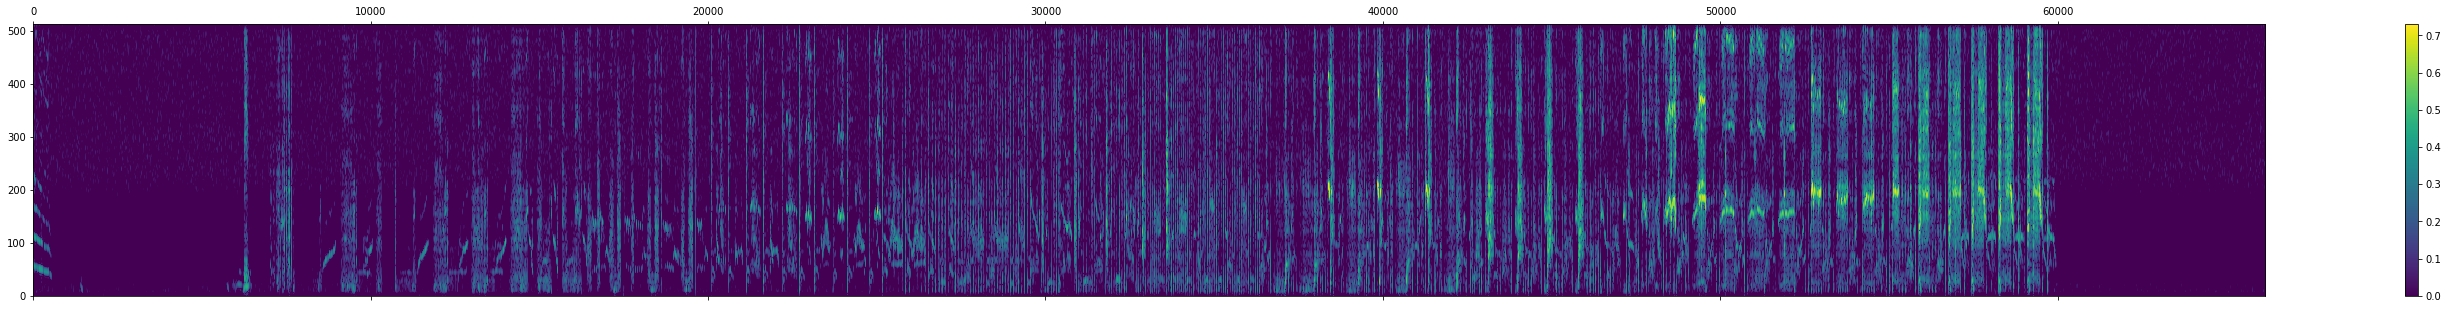

In [89]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(spec, fig=fig, ax=ax, cmap=plt.cm.viridis)
plt.show()

In [93]:
from librosa.display import specshow

In [ ]:
np.shape(spec)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
specshow(spec, sr = rate, hop_length= int(hparams.hop_length_ms*rate), ax = ax)

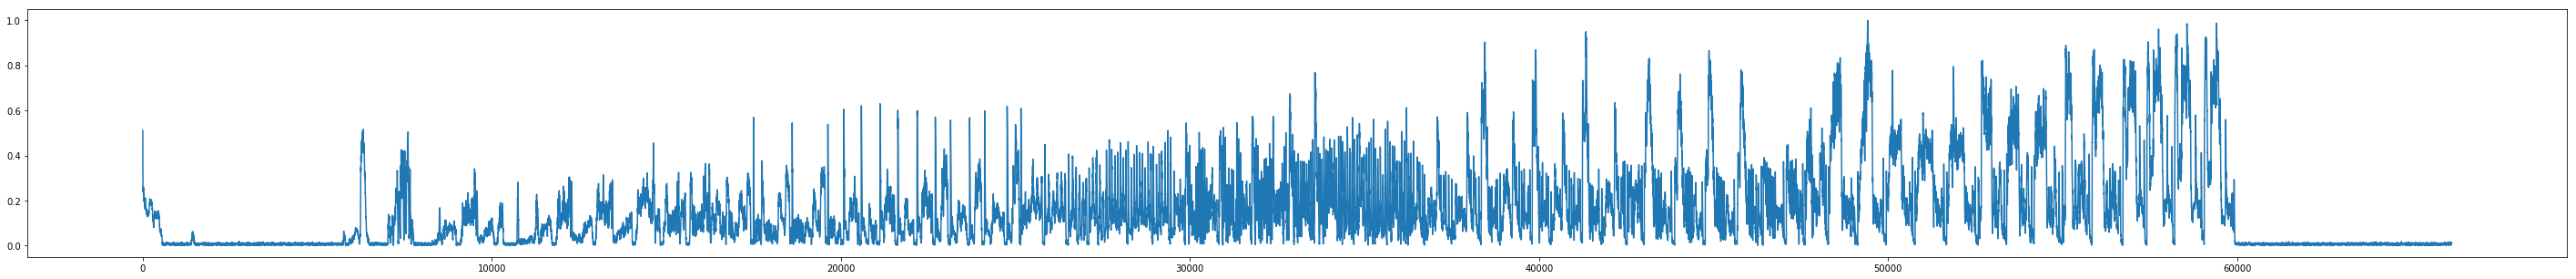

In [90]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(vocal_envelope)